In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor,ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error


import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (16,10)

# Data cleaning

In [2]:
data = pd.read_csv("../data/combined-data.csv")

/home/tuopelto/projects/singapore-hdb-price-prediction/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.shape

(101741, 16)

In [4]:
data.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,mrt_station,Dist_to_station,noise,Park_dist,Bus_stop_dist
0,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,70,255000.0,YIO CHU KANG MRT STATION,823.905301,69.9,217.561750,207.002126
1,2015-01,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1981,65,275000.0,ANG MO KIO MRT STATION,808.563653,69.9,701.207107,59.866879
2,2015-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69.0,New Generation,1980,64,285000.0,YIO CHU KANG MRT STATION,1204.292767,69.9,239.915650,52.872599
3,2015-01,ANG MO KIO,3 ROOM,446,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1979,63,290000.0,BISHAN MRT STATION,1121.890344,69.9,662.396968,10.290987
4,2015-01,ANG MO KIO,3 ROOM,557,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,64,290000.0,BISHAN MRT STATION,1121.890344,69.9,662.396968,10.290987


In [5]:
data = data.dropna()

In [6]:
X = data.drop(columns=['resale_price'])
y = data['resale_price']

In [7]:
for c in X.columns:
    print(X[c].isna().sum())
    print(c, X[c].isnull().any())

0
month False
0
town False
0
flat_type False
0
block False
0
street_name False
0
storey_range False
0
floor_area_sqm False
0
flat_model False
0
lease_commence_date False
0
remaining_lease False
0
mrt_station False
0
Dist_to_station False
0
noise False
0
Park_dist False
0
Bus_stop_dist False


In [8]:
X['remaining_lease'] = X['remaining_lease'].apply(str)

In [9]:
# Categorical features to numeric features

for c in ['month', 'town', 'flat_type', 'block', 'storey_range', 'flat_model', 'mrt_station']:
    X = pd.concat([X, pd.get_dummies(X[c])], axis=1)


tmp = X['remaining_lease'].str.split(" ", n = 1, expand = True)
X["years_left"] = tmp[0]
X["years_left"] = pd.to_numeric(X["years_left"])

X = X.drop(columns=['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'flat_model', 'remaining_lease', 'mrt_station'])

In [10]:
X.head()

,floor_area_sqm,lease_commence_date,Dist_to_station,noise,Park_dist,Bus_stop_dist,2015-01,2015-02,2015-03,2015-04,...,TONGKANG LRT STATION,UBI MRT STATION,UPPER CHANGI MRT STATION,WOODLANDS MRT STATION,WOODLANDS SOUTH MRT STATION,WOODLEIGH MRT STATION,YEW TEE MRT STATION,YIO CHU KANG MRT STATION,YISHUN MRT STATION,years_left
0,60.0,1986,823.905301,69.9,217.561750,207.002126,1,0,0,0,...,0,0,0,0,0,0,0,1,0,70
1,68.0,1981,808.563653,69.9,701.207107,59.866879,1,0,0,0,...,0,0,0,0,0,0,0,0,0,65
2,69.0,1980,1204.292767,69.9,239.915650,52.872599,1,0,0,0,...,0,0,0,0,0,0,0,1,0,64
3,68.0,1979,1121.890344,69.9,662.396968,10.290987,1,0,0,0,...,0,0,0,0,0,0,0,0,0,63
4,68.0,1980,1121.890344,69.9,662.396968,10.290987,1,0,0,0,...,0,0,0,0,0,0,0,0,0,64


In [11]:
# Train, validation, and test split
train_split = 0.8
validation_split = 0.1
test_split = 0.1

train_X = X.iloc[:round(len(data)*train_split),:]
train_y = y.iloc[:round(len(data)*train_split)]

validation_X = X.iloc[round(len(data)*train_split):round(len(data)*train_split + len(data)*validation_split)]
validation_y = y.iloc[round(len(data)*train_split):round(len(data)*train_split + len(data)*validation_split)]


test_X = X.iloc[round(len(data)*train_split + len(data)*validation_split):,:]
test_y = y.iloc[round(len(data)*train_split + len(data)*validation_split):]

In [12]:
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((61794, 2583), (61794,), (7724, 2583), (7724,))

# Modeling

In [13]:
model = RandomForestRegressor(verbose=3)
model.fit(train_X, train_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.3s remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  6.2min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=3, warm_start=False)

# Validation

In [14]:
validation_predictions = model.predict(validation_X)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


In [15]:
mae = mean_absolute_error(y_true=validation_y, y_pred=validation_predictions)
mae, mae/np.mean(validation_y)

(26197.072571940276, 0.061077290436688095)

In [16]:
r2 = r2_score(y_true=validation_y, y_pred=validation_predictions)

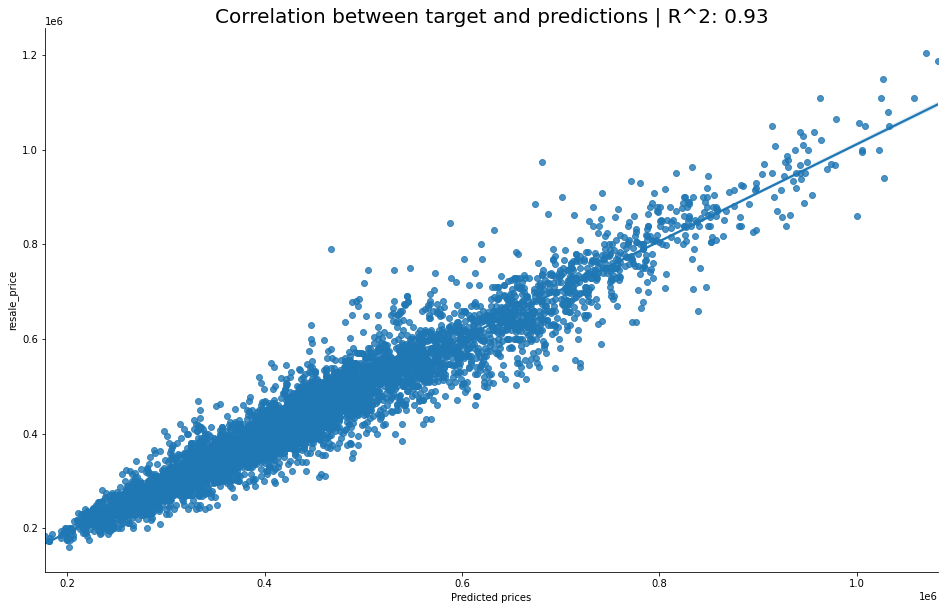

In [17]:
fig, ax = plt.subplots(figsize=(16, 10))

plt.title(f"Correlation between target and predictions | R^2: {round(r2, ndigits=2)}", fontsize=20)
plt.xlabel("Predicted prices")
plt.ylabel("Target prices")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

sns.regplot(validation_predictions, validation_y)

# Feature importance

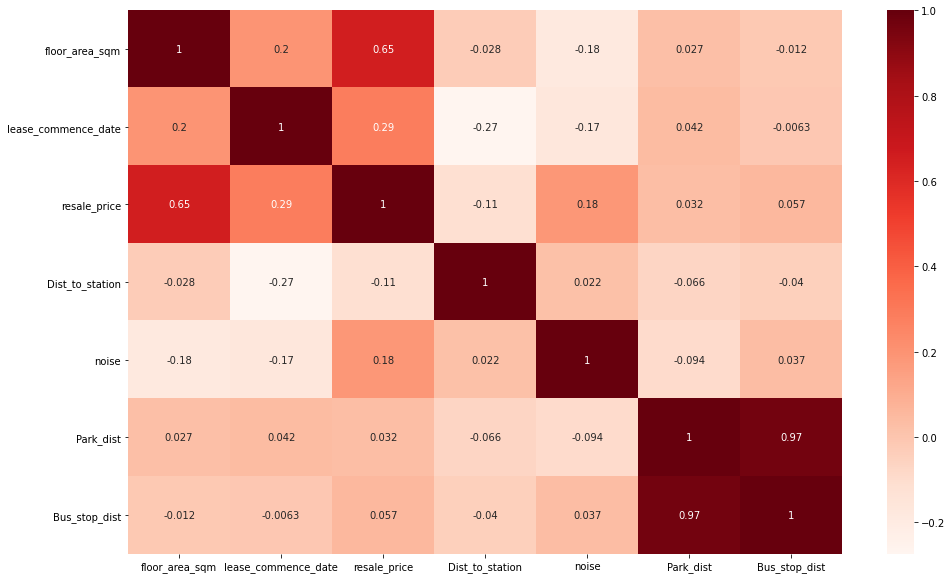

In [18]:
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [19]:
feature_importances = model.feature_importances_
feature_importances = pd.concat([pd.Series(X.columns),pd.Series(feature_importances)],axis=1)
feature_importances.columns = ['feature', 'importance']
feature_importances = feature_importances.sort_values(['importance'], ascending=False)

In [20]:
feature_importances[:20]

,feature,importance
0,floor_area_sqm,0.472318
3,noise,0.155471
91,YISHUN,0.095782
1,lease_commence_date,0.077074
2582,years_left,0.016166
66,ANG MO KIO,0.015783
2,Dist_to_station,0.015608
4,Park_dist,0.014437
2457,Model A,0.012246
2433,01 TO 03,0.008200


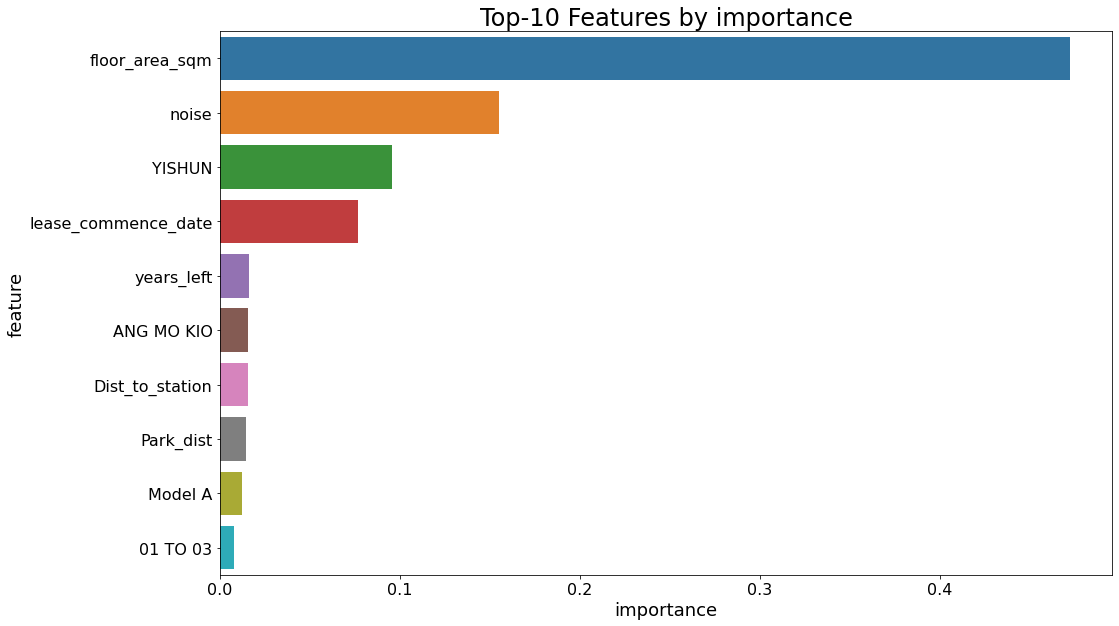

In [21]:
plt.title("Top-10 Features by importance",fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("",fontsize=18)
plt.ylabel("",fontsize=18)
sns.barplot(x=feature_importances.importance[:10], y=feature_importances.feature[:10])

# Dropping those features

In [22]:
def train_test_split(X):
    train_split = 0.8
    validation_split = 0.1
    test_split = 0.1

    
    
    train_X = X[:round(len(data)*train_split),:]
    train_y = y[:round(len(data)*train_split)]

    validation_X = X[round(len(data)*train_split):round(len(data)*train_split + len(data)*validation_split),:]
    validation_y = y[round(len(data)*train_split):round(len(data)*train_split + len(data)*validation_split)]


    test_X = X[round(len(data)*train_split + len(data)*validation_split):,:]
    test_y = y[round(len(data)*train_split + len(data)*validation_split)]
    
    return train_X, train_y, validation_X, validation_y, test_X, test_y

K-features: 50


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   20.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


MAE: 29477.116122011375 MAE (%): 0.06872456369603916


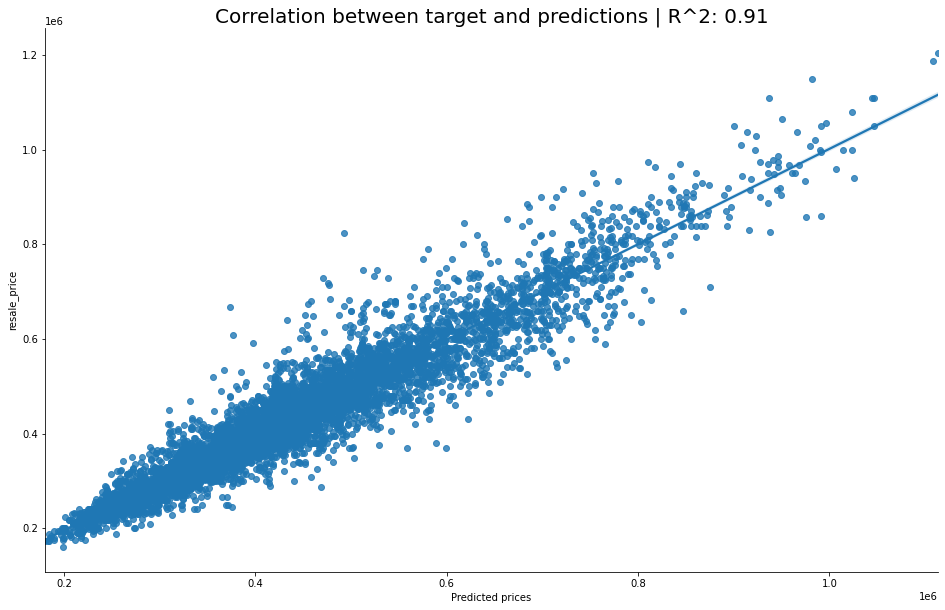

##################################################################################


In [27]:
for k_features in [50]:
    print("K-features:", k_features)
    
    X_new = SelectKBest(f_regression, k=k_features).fit_transform(X, y)
    
    # Train, validation, and test split
    tmp_train_X, tmp_train_y, tmp_validation_X, tmp_validation_y, tmp_test_X, tmp_test_y = train_test_split(X_new)
    
    # Training
    tmp_model = RandomForestRegressor(verbose=3)
    tmp_model.fit(tmp_train_X, tmp_train_y)
    
    # Validation
    test_predictions = tmp_model.predict(tmp_validation_X)

    mae = mean_absolute_error(y_true=tmp_validation_y, y_pred=test_predictions)
    print("MAE:", mae, "MAE (%):", mae/np.mean(tmp_validation_y))

    r2 = r2_score(y_true=tmp_validation_y, y_pred=test_predictions)

    fig, ax = plt.subplots(figsize=(16, 10))

    plt.title(f"Correlation between target and predictions | R^2: {round(r2, ndigits=2)}", fontsize=20)
    plt.xlabel("Predicted prices")
    plt.ylabel("Target prices")

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    sns.regplot(test_predictions, tmp_validation_y)
    plt.show()
    
    print("##################################################################################")
    
    

K-features: 2583


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.6s remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  6.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


MAE: 26376.763626805954 MAE (%): 0.06149623200799409


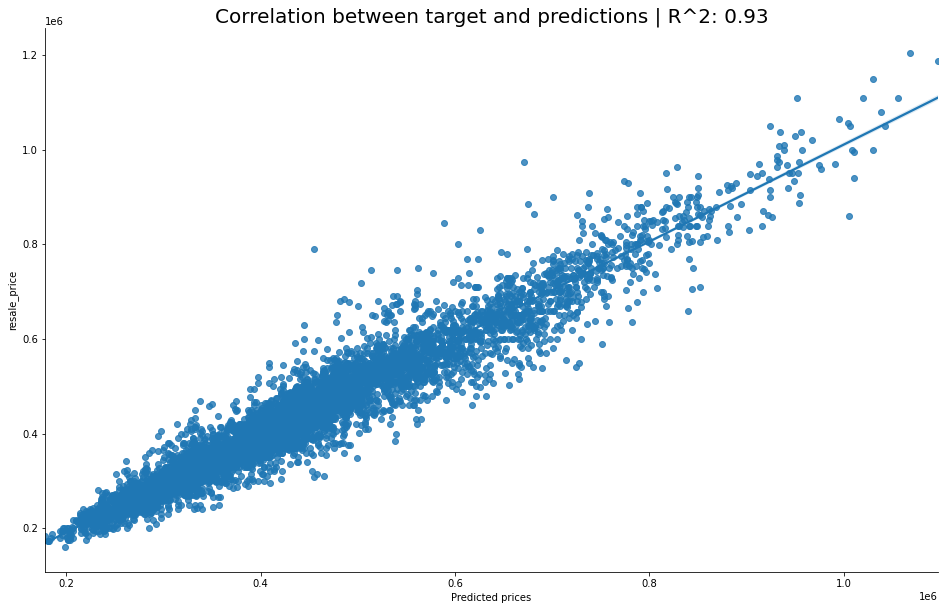

##################################################################################
K-features: 1000


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


MAE: 26215.563080137767 MAE (%): 0.061120400220668676


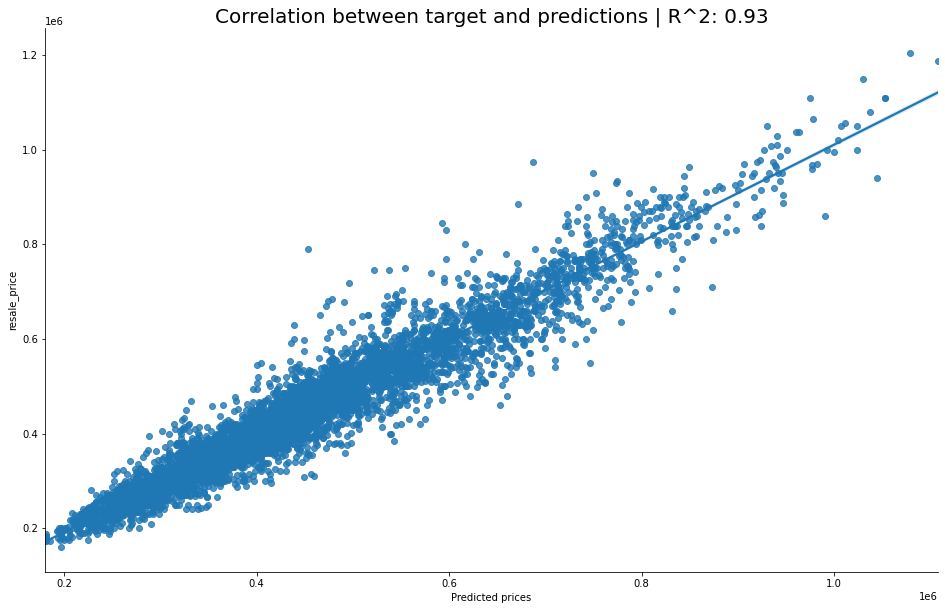

##################################################################################
K-features: 100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   34.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


MAE: 26925.338557254276 MAE (%): 0.06277520965945756


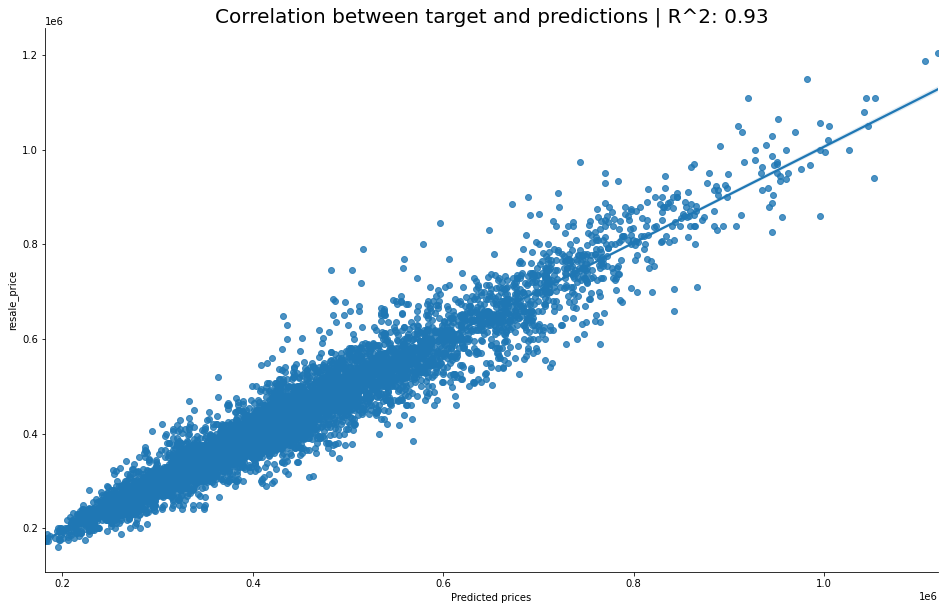

##################################################################################
K-features: 10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


MAE: 57817.536653118965 MAE (%): 0.1347989730073439


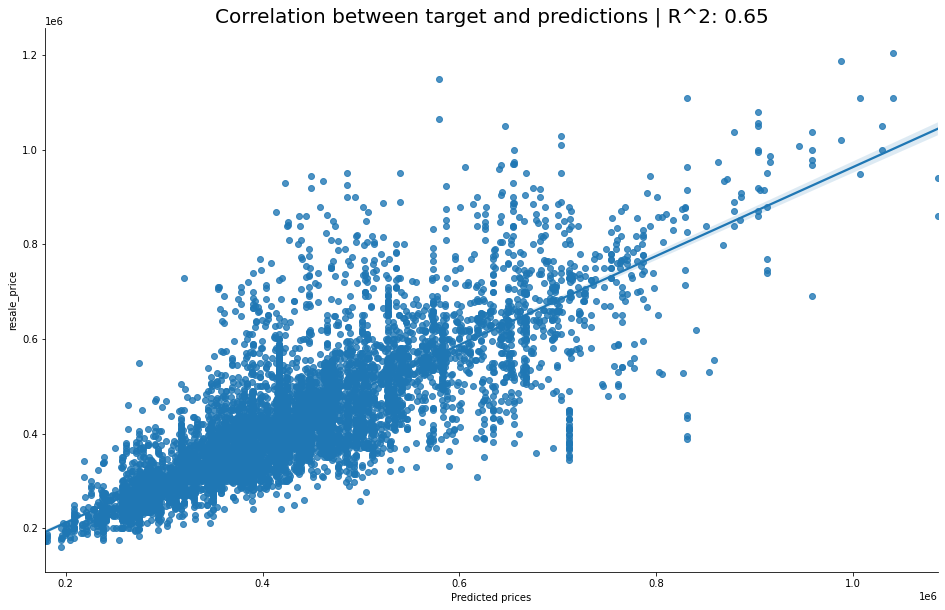

##################################################################################


In [23]:
for k_features in [X.shape[1],1000, 100, 10]:
    print("K-features:", k_features)
    
    X_new = SelectKBest(f_regression, k=k_features).fit_transform(X, y)
    
    # Train, validation, and test split
    tmp_train_X, tmp_train_y, tmp_validation_X, tmp_validation_y, tmp_test_X, tmp_test_y = train_test_split(X_new)
    
    # Training
    tmp_model = RandomForestRegressor(verbose=3)
    tmp_model.fit(tmp_train_X, tmp_train_y)
    
    # Validation
    test_predictions = tmp_model.predict(tmp_validation_X)

    mae = mean_absolute_error(y_true=tmp_validation_y, y_pred=test_predictions)
    print("MAE:", mae, "MAE (%):", mae/np.mean(tmp_validation_y))

    r2 = r2_score(y_true=tmp_validation_y, y_pred=test_predictions)

    fig, ax = plt.subplots(figsize=(16, 10))

    plt.title(f"Correlation between target and predictions | R^2: {round(r2, ndigits=2)}", fontsize=20)
    plt.xlabel("Predicted prices")
    plt.ylabel("Target prices")

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    sns.regplot(test_predictions, tmp_validation_y)
    plt.show()
    
    print("##################################################################################")
    
    

# Hyperparameter tuning

Since the original model with every feature seems to perform the best, we'll continue using it, but now we'll dive into the hyperparameter tuning

In [28]:
# Select only 100 features for this process, as otherwise it will take days
X_new = SelectKBest(f_regression, k=50).fit_transform(X, y)
    
# Train, validation, and test split
tmp_train_X, tmp_train_y, tmp_validation_X, tmp_validation_y, tmp_test_X, tmp_test_y = train_test_split(X_new)

In [31]:
model_ = RandomForestRegressor(random_state=42)
#Cs = [1, 10, 100, 1000]
#Gammas = [1e-3, 1e-4]

parameters= {
    'bootstrap': [True],
    'max_depth': [None, 10, 30],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [100, 250, 500]
}

gs = GridSearchCV(model_,parameters,cv=3,n_jobs=-1,verbose=10)

gs.fit(tmp_train_X, tmp_train_y)

#scores = [x[kolumni indeksi] for x in gs.grid_scores_]
#scores = np.array(scores).reshape(len(Cs), len(Gammas))

#for ind, i in enumerate(Cs):
#    plt.plot(Gammas, scores[ind], label='C: ' + str(i))
#plt.legend()
#plt.xlabel('Gamma')
#plt.ylabel('Mean score')
#plt.show() 

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 22.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 25

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [45]:
top_params = gs.best_params_
top_params

{'bootstrap': True,
 'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 500}

# Updated modeling

In [46]:
model = RandomForestRegressor(max_depth=30, max_features="auto",
                              min_samples_leaf=1,min_samples_split=4,
                              n_estimators=500, n_jobs=-1,verbose=3)
model.fit(train_X, train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500building tree 5 of 500
building tree 6 of 500

building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   14.6s


building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.8min


building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  4.5min


building tree 280 of 500
building tree 281 of 500
building tree 282 of 500
building tree 283 of 500
building tree 284 of 500
building tree 285 of 500
building tree 286 of 500
building tree 287 of 500
building tree 288 of 500
building tree 289 of 500
building tree 290 of 500
building tree 291 of 500
building tree 292 of 500
building tree 293 of 500
building tree 294 of 500
building tree 295 of 500
building tree 296 of 500
building tree 297 of 500
building tree 298 of 500
building tree 299 of 500
building tree 300 of 500
building tree 301 of 500
building tree 302 of 500
building tree 303 of 500
building tree 304 of 500
building tree 305 of 500
building tree 306 of 500
building tree 307 of 500
building tree 308 of 500
building tree 309 of 500
building tree 310 of 500
building tree 311 of 500
building tree 312 of 500
building tree 313 of 500
building tree 314 of 500
building tree 315 of 500
building tree 316 of 500
building tree 317 of 500
building tree 318 of 500
building tree 319 of 500


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.9min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=3, warm_start=False)

# Validation

In [47]:
validation_predictions = model.predict(validation_X)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.5s finished


In [48]:
mae = mean_absolute_error(y_true=validation_y, y_pred=validation_predictions)
mae, mae/np.mean(validation_y)

(26354.92757589088, 0.06144532224240605)

In [49]:
r2 = r2_score(y_true=validation_y, y_pred=validation_predictions)

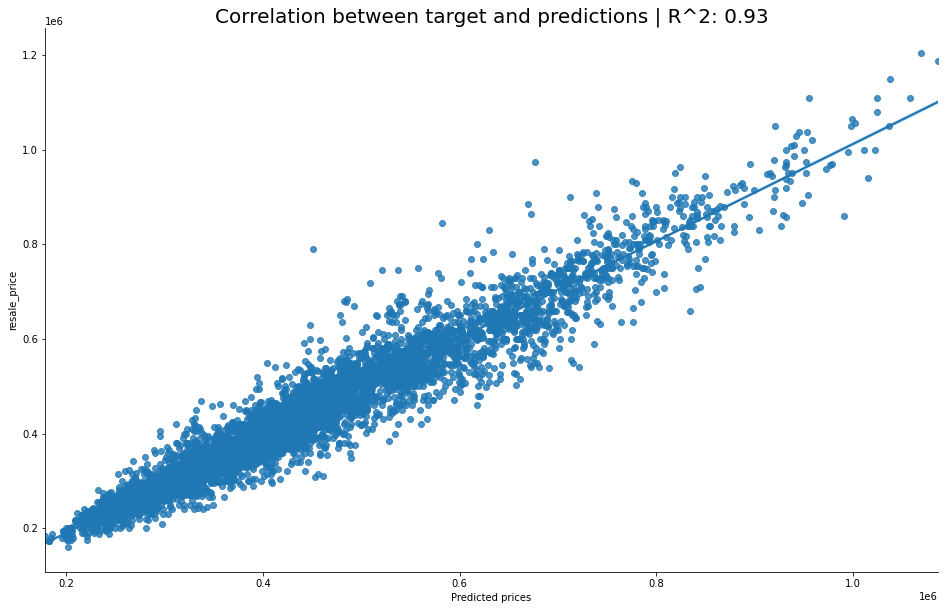

In [50]:
fig, ax = plt.subplots(figsize=(16, 10))

plt.title(f"Correlation between target and predictions | R^2: {round(r2, ndigits=2)}", fontsize=20)
plt.xlabel("Predicted prices")
plt.ylabel("Target prices")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

sns.regplot(validation_predictions, validation_y)

In [51]:
test_predictions = model.predict(test_X)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.5s finished


In [52]:
mae = mean_absolute_error(y_true=test_y, y_pred=test_predictions)
mae, mae/np.mean(test_y)

(28164.928634491975, 0.06584976349866783)

In [53]:
r2 = r2_score(y_true=test_y, y_pred=test_predictions)

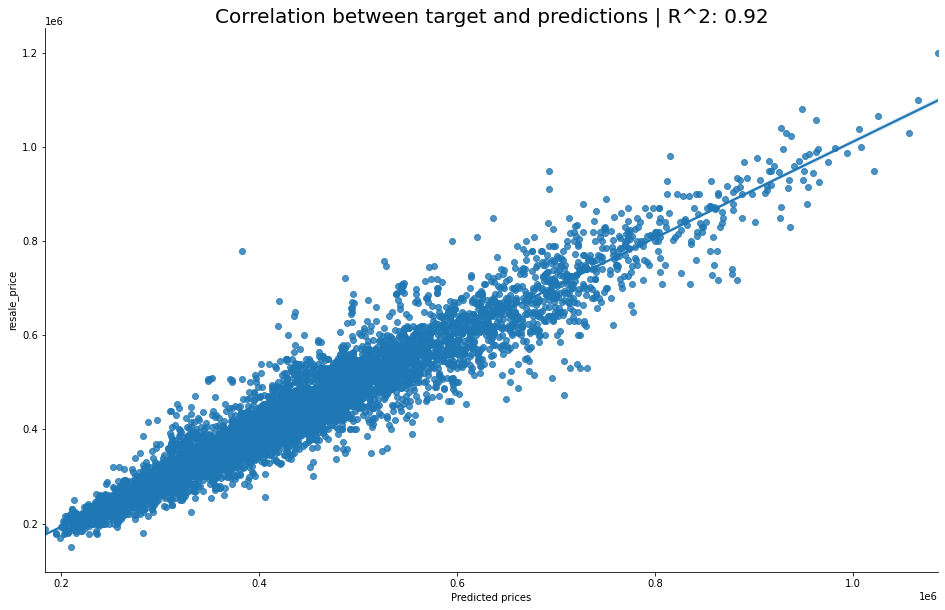

In [54]:
fig, ax = plt.subplots(figsize=(16, 10))

plt.title(f"Correlation between target and predictions | R^2: {round(r2, ndigits=2)}", fontsize=20)
plt.xlabel("Predicted prices")
plt.ylabel("Target prices")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

sns.regplot(test_predictions, test_y)

In [ ]:
model2_ = RandomForestRegressor(random_state=42)
#Cs = [1, 10, 100, 1000]
#Gammas = [1e-3, 1e-4]

parameters= {
    'n_estimators': [1000, 1500, 2000]
}

gs2 = GridSearchCV(model2_,parameters,cv=3,n_jobs=-1,verbose=10)

gs2.fit(tmp_train_X, tmp_train_y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [ ]:
top_params2 = gs2.best_params_
top_params2